# LeNet5 using PyTorch

The data set is the MNIST data set, and the CNN model is LeNet.

**Reference**:

[1] Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.

[2] https://github.com/salmanazarr/LeNet-5



# Data Set

Explore the data set first

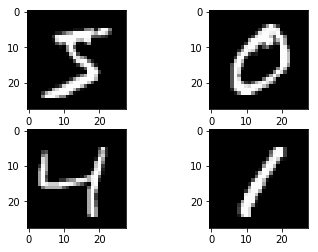

In [1]:
# MNIST data set
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
%matplotlib inline

# Plot ad hoc mnist instances

# load (download if needed) the MNIST dataset
mnist_train = MNIST(".", train=True, download=True)

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(mnist_train.train_data[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(mnist_train.train_data[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(mnist_train.train_data[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(mnist_train.train_data[3], cmap=plt.get_cmap('gray'))

# show the plot
# plt.show()

In [11]:
# to show the picture.be careful to add the .train_data
# Check the source code to get the detail.
mnist_train.train_data.size()
# mnist_train.data

torch.Size([60000, 28, 28])

## Network

Implement the LeNet5 network

In this block, I defined the nerual network.

In [13]:
import torch
import torch.nn as nn
from collections import OrderedDict

class LeNet5(nn.Module):
    '''
    LeNet5:

    Input: 1*32*32

    C1- 6@28*28(5*5 kernel)

    tanh/ Relu

    S2- 6@14*14(2*2 kernel, stride=2) pooling layer

    C3- 16@10*10(5*5 kernel, stride=1) 

    tanh/Relu

    S4- 16@5*5 (2*2 kernel, stride=2) pooling layer

    C5- 120@1*1 (5*5 kernel, no stride) --make it into fully connected

    tanh/Relu

    F6- 84 tanh/Relu 

    F7- 10 Softmax output 

    '''  
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

# Processing and Run the Network



In [12]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# import visdom
import torch.optim as optim

In [14]:
data_train = MNIST('.',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))
data_test = MNIST('.',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))

In [15]:
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=8) 


In [16]:
# viz = visdom.Visdom()

net = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=2e-3)



cur_batch_win = None
cur_batch_win_opts = {
    'title': 'Epoch Loss Trace',
    'xlabel': 'Batch Number',
    'ylabel': 'Loss',
    'width': 1200,
    'height': 600,
}


def train(epoch):
    global cur_batch_win
    
    # train mode
    net.train()
    
    loss_list, batch_list = [], []
    for i, (images, labels) in enumerate(data_train_loader):
      
#       clear the grad in each loop 
        optimizer.zero_grad()

        output = net(images) # input and get the output 

        loss = criterion(output, labels)  # compute the loss 

        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)

        if i % 10 == 0:
            print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))

        # Update Visualization
#         if viz.check_connection():
#             cur_batch_win = viz.line(torch.Tensor(loss_list), torch.Tensor(batch_list),
#                                      win=cur_batch_win, name='current_batch_loss',
#                                      update=(None if cur_batch_win is None else 'replace'),
#                                      opts=cur_batch_win_opts)

        loss.backward()
        optimizer.step()
        
        
def test():
#   eval mode
    net.eval()
  
    total_correct = 0
    avg_loss = 0.0
    for i, (images, labels) in enumerate(data_test_loader):
        output = net(images)
        avg_loss += criterion(output, labels).sum()
        pred = output.detach().max(1)[1]  # get the prediction value
        total_correct += pred.eq(labels.view_as(pred)).sum()  # sum all the correct ones

    avg_loss /= len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct) / len(data_test)))

    
def train_and_test(epoch):
    train(epoch)
    test()


def main():
#   16 epoches
    for e in range(1, 16):
        train_and_test(e)


# if __name__ == '__main__':
#     main()
main()

Train - Epoch 1, Batch: 0, Loss: 2.304988
Train - Epoch 1, Batch: 10, Loss: 2.031821
Train - Epoch 1, Batch: 20, Loss: 1.128323
Train - Epoch 1, Batch: 30, Loss: 0.594330
Train - Epoch 1, Batch: 40, Loss: 0.597969
Train - Epoch 1, Batch: 50, Loss: 0.460162
Train - Epoch 1, Batch: 60, Loss: 0.385199
Train - Epoch 1, Batch: 70, Loss: 0.367071
Train - Epoch 1, Batch: 80, Loss: 0.414887
Train - Epoch 1, Batch: 90, Loss: 0.263471
Train - Epoch 1, Batch: 100, Loss: 0.278532
Train - Epoch 1, Batch: 110, Loss: 0.331094
Train - Epoch 1, Batch: 120, Loss: 0.325250
Train - Epoch 1, Batch: 130, Loss: 0.104509


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _

KeyboardInterrupt: 